In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook, trange
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import SpectralClustering

In [3]:
os.chdir(r"/raid6/roozbeh/trip_similarity/")

In [4]:
with pd.HDFStore("koln_by_hour_OD_and_scaled.h5") as store:
    OD8df = store["OD8df"]
    OD8df_scaled = store["OD8df_scaled"]
    OD12df = store["OD12df"]
    OD12df_scaled = store["OD12df_scaled"]
    OD16df = store["OD16df"]
    OD16df_scaled = store["OD16df_scaled"]
    OD20df = store["OD20df"]
    OD20df_scaled = store["OD20df_scaled"]

In [5]:
with pd.HDFStore("koln_by_hour.h5") as store:
    koln8df = store["koln8"]

##### Parameters Section

In [13]:
spatial_step = 50

time_threshold = 600 #seconds since data is per second

distance_sim_coef = 0.0001
time_sim_coef = 0.00015

##### Let's prepare the OD style of trips

In [14]:
OD8df.describe().loc[['min','max'],]

,time_begin,x_begin,y_begin,time_end,x_end,y_end
min,28800.0,3758.084711,1108.623441,28800.0,3916.012273,1105.472128
max,32399.0,25783.158495,31743.770000,32399.0,25775.636178,31918.184081


In [15]:
x_diff = max(OD8df.x_begin.max(),OD8df.x_end.max()) - min(OD8df.x_begin.min(), OD8df.x_end.min())
y_diff = max(OD8df.y_begin.max(),OD8df.y_end.max()) - min(OD8df.y_begin.min(), OD8df.y_end.min())
min_diff = min(x_diff,y_diff)
min_step = min_diff / spatial_step 
distance_threshold = min_step * np.sqrt(2)
distance_threshold

622.9631611561606

##### We get a sample  2000 for the requests

In [6]:
reqDF = OD8df.sample(n=2000,random_state=1234)
ongoingDF = OD8df[~ OD8df.index.isin(reqDF.index)]

# ongoingDF = OD8df.sample(n=10000,random_state=1234)

# otherDF = OD8df[~ OD8df.index.isin(ongoingDF.index)]

# reqDF = otherDF.sample(n=2000,random_state=1234)

In [7]:
reqDF_scaled = OD8df_scaled.sample(n=2000,random_state=1234)
ongoingDF_scaled = OD8df_scaled[~ OD8df_scaled.index.isin(reqDF_scaled.index)]

In [8]:
koln8df[:2]

,time,trip_id,x,y,spd,hour_of_day
84455778,28800,222454,19053.557601,9789.137665,2.44,8
84455779,28800,1337436,19051.351003,9786.667576,2.19,8


In [9]:
sample_8 = koln8df[koln8df.trip_id.isin(reqDF.index)]

In [10]:
len(sample_8),len(koln8df)

(904163, 18942388)

In [11]:
len(sample_8.groupby("trip_id"))

2000

In [12]:
sample8_50waypoints = sample_8.groupby("trip_id").apply(lambda x: x.sample(n=50) if len(x) > 50 else None).drop('trip_id',axis=1).reset_index().drop(['level_1','spd','hour_of_day'],axis=1)

In [13]:
len(sample8_50waypoints.groupby('trip_id'))

1898

-----
#### SORTING ON TIME BEFORE ADDING WAYPOINT NUMBER

In [14]:
sample8_50wp = sample8_50waypoints.sort_values(['trip_id','time']).reset_index().drop('index',axis=1)

In [15]:
wp_num_series = pd.Series(np.tile(np.arange(50),int(len(sample8_50wp)/50)),name='waypoint')

In [16]:
sample8_50wp['waypoint'] = wp_num_series

In [17]:
del sample8_50waypoints

##### so returning None filters out groups based on above lines! ?

----------

In [18]:
sample8_50wp[:4]

,trip_id,time,x,y,waypoint
0,1000783,32201,10083.170000,23333.110000,0
1,1000783,32204,10090.054606,23341.547672,1
2,1000783,32207,10105.187706,23363.589124,2
3,1000783,32220,10204.876610,23533.322475,3


In [19]:
x_table = sample8_50wp.pivot_table(values='x',index='trip_id',columns='waypoint')
y_table = sample8_50wp.pivot_table(values='y',index='trip_id',columns='waypoint')
t_table = sample8_50wp.pivot_table(values='time',index='trip_id',columns='waypoint')

In [20]:
xy_table = x_table.reset_index().merge(y_table.reset_index(),on="trip_id",suffixes=["_x","_y"])

In [21]:
xy_table.iloc[:5,50:55]

waypoint,49_x,0_y,1_y,2_y,3_y
0,10523.457945,23333.110000,23341.547672,23363.589124,23533.322475
1,11356.759150,15821.418513,15828.677234,15839.809408,15858.760513
2,20713.202248,3449.901390,3495.030622,3450.921509,3409.618381
3,13666.869986,14685.950000,14924.416633,14944.670004,14997.420570
4,17726.900356,17069.337419,17025.142056,16913.775667,16642.946607


In [22]:
sample8_50wp_150feat = xy_table.merge(t_table.reset_index(),on='trip_id')

In [254]:
#I COULD HAVE SIMPLY RENAMED THE COLUMNS :|
# sample8_50wp_150feat = sample8_50wp_150feat.iloc[:,:-50].join(sample8_50wp_150feat.iloc[:,-50:].add_suffix('_t'))

In [23]:
sample8_50wp_150feat.columns=["trip_id"] + [str(i) + "_x" for i in range(50)] + [str(i) + "_y" for i in range(50)] + [ str(i) + "_t" for i in range(50) ]

In [24]:
sample8_50wp_150feat[:2]

,trip_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,40_t,41_t,42_t,43_t,44_t,45_t,46_t,47_t,48_t,49_t
0,1000783,10083.170000,10090.054606,10105.187706,10204.876610,10210.052357,10220.182394,10249.940801,10259.833869,10264.898558,...,32364,32371,32374,32376,32379,32383,32385,32386,32389,32390
1,1000831,11000.695316,11006.133685,11014.474118,11028.672639,11033.193621,11052.122985,11057.111655,11075.291519,11077.504042,...,31661,31662,31664,31666,31667,31669,31671,31673,31679,31682


------
#### TILL THIS POINT WE HAVE 1898 TRIPS WITH 50 SAMPLES EACH IN A DF FORMAT OF 150 COLUMNS (50 x, 50 y, 50 time)


##### NOW LET'S BUILD THIS FOR OTHER TRIPS AS WELL (ONGOING)

In [25]:
ongoing8 = koln8df[ ~ koln8df.trip_id.isin(reqDF.index)]

In [26]:
len(ongoing8.groupby("trip_id"))

40070

In [27]:
ongoing8_50waypoints = ongoing8.groupby("trip_id").apply(lambda x: x.sample(n=50) if len(x) > 50 else None).drop('trip_id',axis=1).reset_index().drop(['level_1','spd','hour_of_day'],axis=1)

In [28]:
ongoing8_50wp = ongoing8_50waypoints.sort_values(['trip_id','time']).reset_index().drop('index',axis=1)

In [29]:
wp_num_series_ongoing8 = pd.Series(np.tile(np.arange(50),int(len(ongoing8_50wp)/50)),name='waypoint')

In [30]:
ongoing8_50wp['waypoint'] = wp_num_series_ongoing8

In [31]:
del ongoing8_50waypoints

In [32]:
x_table_ongoing = ongoing8_50wp.pivot_table(values='x',index='trip_id',columns='waypoint')
y_table_ongoing = ongoing8_50wp.pivot_table(values='y',index='trip_id',columns='waypoint')
t_table_ongoing = ongoing8_50wp.pivot_table(values='time',index='trip_id',columns='waypoint')

In [33]:
xy_table_ongoing = x_table_ongoing.reset_index().merge(y_table_ongoing.reset_index(),on="trip_id",suffixes=["_x","_y"])

In [34]:
ongoing8_50wp_150feat = xy_table_ongoing.merge(t_table_ongoing.reset_index(),on='trip_id')

--------
#### Let's rename the columns as well!

In [35]:
ongoing8_50wp_150feat.columns=["trip_id"] + [str(i) + "_x" for i in range(50)] + [str(i) + "_y" for i in range(50)] + [ str(i) + "_t" for i in range(50) ]

In [36]:
ongoing8_50wp_150feat[:2]

,trip_id,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,40_t,41_t,42_t,43_t,44_t,45_t,46_t,47_t,48_t,49_t
0,1000027,23471.488035,23486.543062,23521.561714,23541.435547,23585.563040,23859.228418,23884.795609,23646.963936,23631.351299,...,30811,30816,30834,30841,30842,30849,30861,30865,30872,30878
1,1000032,14534.970000,14535.797462,14536.475016,14530.998442,14530.228654,14529.828607,14515.831001,14480.438631,14500.702807,...,32371,32374,32375,32378,32382,32390,32391,32394,32396,32398


----------------
#### DEFINING SIMILARITIES

In [310]:
w_x = 0.6
w_t = 0.4

t_th = 900 #seconds
d_th = 1800 #meters

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
# t1 is rider (walker) and t2 is the ride
def get_trip_similarity_from_tuple_WALK2_wgm(t1,t2):
    oo_dist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )

    oo_t = (t2[0] - t1[0]) #t2 should start after t1
    oo_t = 10000 if oo_t < 0 else oo_t
    
    sim = np.exp(w_x * np.log(1./(1+oo_dist/d_th)) + w_t * np.log(1./(1+ oo_t/t_th)) ) 
       
    dd_dist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )
    
    dd_t = (t1[3] - t2[3]) # t2 should finish before t1 so that t1 can walk to its dest
    dd_t = 10000 if dd_t < 0 else dd_t

    sim += np.exp(w_x * np.log(1./(1+dd_dist/d_th) + w_t * np.log(1./(1+ dd_t/t_th)) ) )
    
    return(sim/2)

In [311]:
def is_equal(x,y):
    dist = np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1])**2 )
    t = np.absolute(x[2]-y[2])
    return dist <= d_th and t <= t_th

In [312]:
def lcs(X , Y):
    # find the length of the strings
    m = 50
    n = 50
    
    # declaring the array for storing the dp values
    L = [[None]*(n+1) for i in range(m+1)]
 
    """Following steps build L[m+1][n+1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif is_equal(X[i-1],Y[j-1]):
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j] , L[i][j-1])
 
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[m][n]

In [352]:
def get_trip_similarity_LCSS(t1,t2):
    X = [(t1[i],t1[i+50],t1[i+100]) for i in range(1,51)]
    Y = [(t2[i],t2[i+50],t2[i+100]) for i in range(1,51)]
    l = lcs(X,Y)

    return(l)

In [359]:
results = []
ongoing_counts = dict()

In [360]:
i = 0
for req in sample8_50wp_150feat.itertuples(index=False):
    if i%100 == 0:
        print(i)
    elif(i%10 == 0):
        print('.',end='')
    
    i+=1
    
    potential_matches = ongoing8_50wp_150feat

    OO_time_mask = (req[101] <= potential_matches["0_t"]) & ((potential_matches["0_t"] - req[101])<=t_th) 
    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req[150] >= potential_matches["49_t"]) & (( req[150] - potential_matches["49_t"])<=t_th))

    potential_matches = potential_matches[DD_time_mask]

    OO_distance = np.sqrt( (potential_matches["0_x"] - req[1]) ** 2 + (potential_matches["0_y"] - req[51])**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches["49_x"] - req[50]) ** 2 + (potential_matches["49_y"] - req[100])**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]
    
    if potential_matches.empty:
        results.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_similarity_LCSS(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity",ascending=False)
                        
        results.append( (req, top_matches[:1]) )
        
        if top_matches.index.values[0] in ongoing_counts:
            ongoing_counts[top_matches.index.values[0]]+=1
        else:
            ongoing_counts[top_matches.index.values[0]]=1

0
.........100
.........200
.........300
.........400
.........500
.........600
.........700
.........800
.........900
.........1000
.........1100
.........1200
.........1300
.........1400
.........1500
.........1600
.........1700
.........1800
.........

In [405]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in results:
    reqtemp = get_total_distance_50wp(req)
    req_kms.append(reqtemp)
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        req_with_match_kms.append(reqtemp)
        match_kms.append(get_total_distance_50wp(match))
        oo_kms.append(np.sqrt((match[1] - req[1]) ** 2 + (match[51] - req[51]) ** 2 ))
        dd_kms.append(np.sqrt((match[50] - req[50]) ** 2 + (match[100] - req[100]) ** 2 ))
        oo_times.append(match[101] - req[101])
        dd_times.append(req[150] - match[150])
    

In [406]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1357
match travels (km):  5393.86139893
req travels (km):  11706.3341707
req travels when they have at least one match (km): 7244.17959474
match/match+req ratio:  0.315426883684
match/match+req with at least 1 match ratio:  0.426795687847
origin-origin distance (km):  1442.78270273
dest-dest distance (km):  1421.04652395
origin-origin times (sec):  86071
dest-dest times (sec):  101652


------
#### MATCHING WITH 50 WAYPOINTS AND USING OUR SCORE

In [471]:
w_x = 0.1
w_t = 0.9

t_th = 900 #seconds
d_th = 1800 #meters

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
# t1 is rider (walker) and t2 is the ride
def get_trip_similarity_from_tuple_WALK3_wgm_50points(t1,t2):
    X = [(t1[i],t1[i+50],t1[i+100]) for i in range(1,51)]
    Y = [(t2[i],t2[i+50],t2[i+100]) for i in range(1,51)]
    sim = 0
    for (x1,y1,t1),(x2,y2,t2) in zip(X,Y):
        dist = np.sqrt( (x1 - x2) ** 2 + (y1 - y2)**2 )

        t = np.absolute(t2 - t1)
        
        sim += np.exp(w_x * np.log(1./(1+dist/d_th)) + w_t * np.log(1./(1+ t/t_th)) ) 

    return(sim/50)

In [472]:
results_wgm = []
ongoing_counts_wgm = dict()

In [473]:
i = 0
for req in sample8_50wp_150feat.itertuples(index=False):
    if i%100 == 0:
        print(i)
    elif(i%10 == 0):
        print('.',end='')
    
    i+=1
    
    potential_matches = ongoing8_50wp_150feat

    OO_time_mask = (req[101] <= potential_matches["0_t"]) & ((potential_matches["0_t"] - req[101])<=t_th) 
    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req[150] >= potential_matches["49_t"]) & (( req[150] - potential_matches["49_t"])<=t_th))

    potential_matches = potential_matches[DD_time_mask]

    OO_distance = np.sqrt( (potential_matches["0_x"] - req[1]) ** 2 + (potential_matches["0_y"] - req[51])**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches["49_x"] - req[50]) ** 2 + (potential_matches["49_y"] - req[100])**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results_wgm.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_similarity_from_tuple_WALK3_wgm_50points(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity",ascending=False)
                
        results_wgm.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts_wgm:
            ongoing_counts_wgm[top_matches.index.values[0]]+=1
        else:
            ongoing_counts_wgm[top_matches.index.values[0]]=1




0
.........100
.........200
.........300
.........400
.........500
.........600
.........700
.........800
.........900
.........1000
.........1100
.........1200
.........1300
.........1400
.........1500
.........1600
.........1700
.........1800
.........

In [51]:
def get_total_distance_50wp(trip):
    X = [(trip[i],trip[i+50],trip[i+100]) for i in range(1,51)]
    total = 0
    for (x1,y1,t1),(x2,y2,t2) in zip(X[:-1],X[1:]): #zip list(0..48) with (1..49)
        total += np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return(total)

In [475]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in results_wgm:
    reqtemp = get_total_distance_50wp(req)
    req_kms.append(reqtemp)
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        req_with_match_kms.append(reqtemp)
        match_kms.append(get_total_distance_50wp(match))
        oo_kms.append(np.sqrt((match[1] - req[1]) ** 2 + (match[51] - req[51]) ** 2 ))
        dd_kms.append(np.sqrt((match[50] - req[50]) ** 2 + (match[100] - req[100]) ** 2 ))
        oo_times.append(match[101] - req[101])
        dd_times.append(req[150] - match[150])
        
    

In [476]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1357
match travels (km):  5945.29165051
req travels (km):  11706.3341707
req travels when they have at least one match (km): 7244.17959474
match/match+req ratio:  0.336812694236
match/match+req with at least 1 match ratio:  0.450760423974
origin-origin distance (km):  1203.72496165
dest-dest distance (km):  1255.59738181
origin-origin times (sec):  57896
dest-dest times (sec):  62424


----

### HOW IT CHANGES WITH RESPECT TO W_t

---

In [37]:
t_th = 900 #seconds
d_th = 1800 #meters
#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
# t1 is rider (walker) and t2 is the ride
def get_trip_similarity_from_tuple_WALK3_wgm_50points(t1,t2,w_x,w_t):
    X = [(t1[i],t1[i+50],t1[i+100]) for i in range(1,51)]
    Y = [(t2[i],t2[i+50],t2[i+100]) for i in range(1,51)]
    sim = 0
    for (x1,y1,t1),(x2,y2,t2) in zip(X,Y):
        dist = np.sqrt( (x1 - x2) ** 2 + (y1 - y2)**2 )

        t = np.absolute(t2 - t1)

        sim += np.exp(w_x * np.log(1./(1+dist/d_th)) + w_t * np.log(1./(1+ t/t_th)) ) 

    return(sim/50)

In [48]:
results_wgm = []
ongoing_counts_wgm = dict()
i = 0
for req in sample8_50wp_150feat.itertuples(index=False):
    if i % 200 == 0:
        print(i)
    elif(i%10 == 0):
        print('.',end='')

    i+=1

    potential_matches = ongoing8_50wp_150feat

    OO_time_mask = (req[101] <= potential_matches["0_t"]) & ((potential_matches["0_t"] - req[101])<=t_th) 
    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req[150] >= potential_matches["49_t"]) & (( req[150] - potential_matches["49_t"])<=t_th))

    potential_matches = potential_matches[DD_time_mask]

    OO_distance = np.sqrt( (potential_matches["0_x"] - req[1]) ** 2 + (potential_matches["0_y"] - req[51])**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches["49_x"] - req[50]) ** 2 + (potential_matches["49_y"] - req[100])**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results_wgm.append((req,None))
    else:
        results_per_wt = []
        for w_t in [0.1*i for i in range(10)]:
            w_x = 1 - w_t
            
            potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_similarity_from_tuple_WALK3_wgm_50points(req,t,w_x,w_t),axis=1)

            top_matches = potential_matches.sort_values(by="similarity",ascending=False)
            results_per_wt.append((w_t,top_matches[:5]))
            
        results_wgm.append( (req, results_per_wt) )

#             if top_matches.index.values[0] in ongoing_counts_wgm:
#                 ongoing_counts_wgm[top_matches.index.values[0]]+=1
#             else:
#                 ongoing_counts_wgm[top_matches.index.values[0]]=1


0
...................200
...................400
...................600
...................800
...................1000
...................1200
...................1400
...................1600
...................1800
.........

In [52]:
# match_count = 0
match_kms = dict()
# req_with_match_kms = []
# req_kms = []
oo_kms = dict()
dd_kms = dict()
oo_times = dict()
dd_times= dict()

for w_t in [0.1*i for i in range(10)]:
    match_kms[w_t] = []
    oo_kms[w_t] = []
    dd_kms[w_t] = []
    oo_times[w_t] = []
    dd_times[w_t] = []
for req, matches in results_wgm:
#     reqtemp = get_total_distance_50wp(req)
#     req_kms.append(reqtemp)
    if(matches is not None):
        
        for w_t, matchdf in matches: #matches of the form tuple(w_t,top_5_matches)
            match = matchdf.iloc[0]
#             match_count+=1
#             req_with_match_kms.append(reqtemp)
            match_kms[w_t].append(get_total_distance_50wp(match))
            oo_kms[w_t].append(np.sqrt((match[1] - req[1]) ** 2 + (match[51] - req[51]) ** 2 ))
            dd_kms[w_t].append(np.sqrt((match[50] - req[50]) ** 2 + (match[100] - req[100]) ** 2 ))
            oo_times[w_t].append(match[101] - req[101])
            dd_times[w_t].append(req[150] - match[150])

In [64]:
results_per_wt_df = pd.DataFrame(columns=["oo_kms","dd_kms","oo_times","dd_times","match_kms"])

In [75]:
temp_list_results = []

In [76]:
for ookms,ddkms,oot,ddt,mkms in zip(oo_kms.values(),dd_kms.values(),oo_times.values(),dd_times.values(),match_kms.values()):
    temp_list_results.append([np.sum(ookms)/1000,np.sum(ddkms)/1000,np.sum(oot),np.sum(ddt),np.sum(mkms)/1000])

In [77]:
results_per_wt_df = pd.DataFrame(temp_list_results,columns=["oo_kms","dd_kms","oo_times","dd_times","match_kms"])


In [79]:
results_per_wt_df["w_t"] = [i*0.1 for i in range(10)]

In [80]:
results_per_wt_df

,oo_kms,dd_kms,oo_times,dd_times,match_kms,w_t
0,1206.959928,1184.551782,78996,90093,5532.967620,0.0
1,1201.259125,1180.198344,78591,87883,5550.480357,0.1
2,1202.269248,1180.492377,77740,86684,5570.621864,0.2
3,1198.839469,1178.154748,76093,85858,5592.888780,0.3
4,1199.097200,1184.873883,75744,84252,5604.248719,0.4
5,1192.882723,1188.556900,74134,81653,5625.544322,0.5
6,1197.916285,1191.221013,72141,78845,5666.338730,0.6
7,1200.712887,1205.884339,69201,75584,5726.283775,0.7
8,1211.046162,1212.746456,66222,71923,5792.334243,0.8
9,1250.811061,1262.509060,60984,67247,5889.557164,0.9


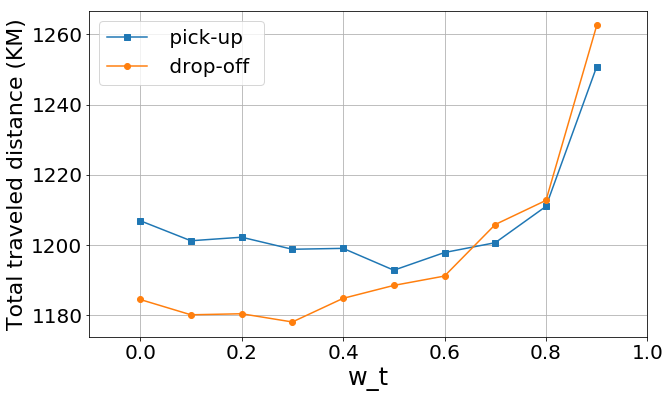

In [110]:
plt.figure(figsize=(10,6))
plt.plot(results_per_wt_df["w_t"],results_per_wt_df["oo_kms"],label=" pick-up ",marker='s')
plt.plot(results_per_wt_df["w_t"],results_per_wt_df["dd_kms"],label=" drop-off ",marker="o")
ax = plt.gca()
ax.set_xlim((-.1,1))
ax.set_xlabel("w_t",fontsize=24)
ax.set_ylabel("Total traveled distance (KM)",fontsize=22)
plt.grid()
plt.legend(prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

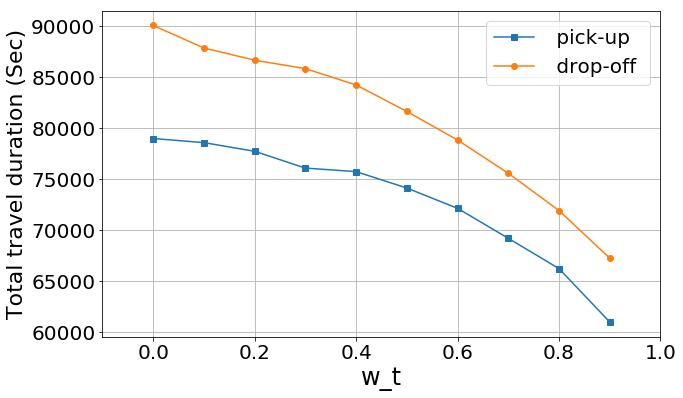

In [111]:
plt.figure(figsize=(10,6))
plt.plot(results_per_wt_df["w_t"],results_per_wt_df["oo_times"],label=" pick-up ",marker='s')
plt.plot(results_per_wt_df["w_t"],results_per_wt_df["dd_times"],label=" drop-off ",marker='o')
ax = plt.gca()
ax.set_xlim((-.1,1))
ax.set_xlabel("w_t",fontsize=24)
ax.set_ylabel("Total travel duration (Sec)",fontsize=22)
plt.grid()
plt.legend(prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

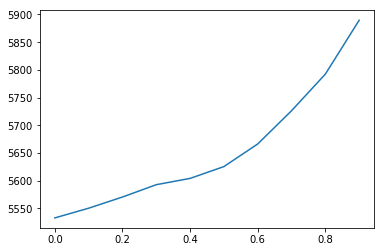

In [87]:
plt.plot(results_per_wt_df["w_t"],results_per_wt_df["match_kms"])
plt.show()

### MATCHING 50 WAYPOINTS WITH APPROX FRECHET
----

In [409]:
# Euclidean distance.
def euc_dist(pt1,pt2):
    return (np.sqrt( (pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1])**2 ))

def _c(ca,i,j,P,Q):
    if ca[i,j] > -1:
        return ca[i,j]
    elif i == 0 and j == 0:
        ca[i,j] = euc_dist(P[0],Q[0])
    elif i > 0 and j == 0:
        ca[i,j] = max(_c(ca,i-1,0,P,Q),euc_dist(P[i],Q[0]))
    elif i == 0 and j > 0:
        ca[i,j] = max(_c(ca,0,j-1,P,Q),euc_dist(P[0],Q[j]))
    elif i > 0 and j > 0:
        ca[i,j] = max(min(_c(ca,i-1,j,P,Q),_c(ca,i-1,j-1,P,Q),_c(ca,i,j-1,P,Q)),euc_dist(P[i],Q[j]))
    else:
        ca[i,j] = float("inf")
    return ca[i,j]

""" Computes the discrete frechet distance between two polygonal lines
Algorithm: http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
P and Q are arrays of 2-element arrays (points)
"""
def frechetDist(P,Q):
    ca = np.ones((len(P),len(Q)))
    ca = np.multiply(ca,-1)
    return _c(ca,len(P)-1,len(Q)-1,P,Q)

In [411]:
def get_trip_distance_FRECHET(t1,t2):
    X = [(t1[i],t1[i+50]) for i in range(1,51)]
    Y = [(t2[i],t2[i+50]) for i in range(1,51)]
    
    return(frechetDist(X,Y))

In [416]:
results_frechet = []
ongoing_counts_frechet = dict()

In [417]:
i = 0
for req in sample8_50wp_150feat.itertuples(index=False):
    if i%100 == 0:
        print(i)
    elif(i%10 == 0):
        print('.',end='')
    
    i+=1
    
    potential_matches = ongoing8_50wp_150feat

    OO_time_mask = (req[101] <= potential_matches["0_t"]) & ((potential_matches["0_t"] - req[101])<=t_th) 
    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req[150] >= potential_matches["49_t"]) & (( req[150] - potential_matches["49_t"])<=t_th))

    potential_matches = potential_matches[DD_time_mask]

    OO_distance = np.sqrt( (potential_matches["0_x"] - req[1]) ** 2 + (potential_matches["0_y"] - req[51])**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches["49_x"] - req[50]) ** 2 + (potential_matches["49_y"] - req[100])**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results_frechet.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_distance_FRECHET(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity")### WE HAVE USED FRECHET DISTANCE NOT SIMILARITY SO SORT ASCENDING CHOOSE LOWEST 
                
        results_frechet.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts_frechet:
            ongoing_counts_frechet[top_matches.index.values[0]]+=1
        else:
            ongoing_counts_frechet[top_matches.index.values[0]]=1




0
.........100
.........200
.........300
.........400
.........500
.........600
.........700
.........800
.........900
.........1000
.........1100
.........1200
.........1300
.........1400
.........1500
.........1600
.........1700
.........1800
.........

In [418]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in results_frechet:
    reqtemp = get_total_distance_50wp(req)
    req_kms.append(reqtemp)
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        req_with_match_kms.append(reqtemp)
        match_kms.append(get_total_distance_50wp(match))
        oo_kms.append(np.sqrt((match[1] - req[1]) ** 2 + (match[51] - req[51]) ** 2 ))
        dd_kms.append(np.sqrt((match[50] - req[50]) ** 2 + (match[100] - req[100]) ** 2 ))
        oo_times.append(match[101] - req[101])
        dd_times.append(req[150] - match[150])
        
    

In [419]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1357
match travels (km):  5671.63144622
req travels (km):  11706.3341707
req travels when they have at least one match (km): 7244.17959474
match/match+req ratio:  0.326369125779
match/match+req with at least 1 match ratio:  0.43912313584
origin-origin distance (km):  1104.90798796
dest-dest distance (km):  1144.94785257
origin-origin times (sec):  74544
dest-dest times (sec):  89570


### MATCHING WITH DTW 50 waypoints
----

In [429]:
def pointwise_distance(p1,p2):
    return (np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2 ))

In [460]:
def dtw(X , Y):
    # find the length of the strings
    m = 50
    n = 50
    
    # declaring the array for storing the dp values
    L = np.full((n+1,m+1),np.inf)
    L[0,0] = 0
    
    """Following steps build L[m+1][n+1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(1,m+1):
        for j in range(1,n+1):
            L[i,j] = pointwise_distance(X[i-1],Y[j-1])*(np.absolute(X[i-1][2]-Y[j-1][2]))/3600 + min(L[i-1,j],L[i-1,j-1],L[i,j-1])

    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[n,m]

In [461]:
def get_trip_distance_DTW(t1,t2):
    X = [(t1[i],t1[i+50],t1[i+100]) for i in range(1,51)]
    Y = [(t2[i],t2[i+50],t2[i+100]) for i in range(1,51)]
    l = dtw(X,Y)

    return(l)

In [462]:
results_dtw = []
ongoing_counts_dtw = dict()

In [463]:
i = 0
for req in sample8_50wp_150feat.itertuples(index=False):
    if i%100 == 0:
        print(i)
    elif(i%10 == 0):
        print('.',end='')
    
    i+=1
    
    potential_matches = ongoing8_50wp_150feat

    OO_time_mask = (req[101] <= potential_matches["0_t"]) & ((potential_matches["0_t"] - req[101])<=t_th) 
    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req[150] >= potential_matches["49_t"]) & (( req[150] - potential_matches["49_t"])<=t_th))

    potential_matches = potential_matches[DD_time_mask]

    OO_distance = np.sqrt( (potential_matches["0_x"] - req[1]) ** 2 + (potential_matches["0_y"] - req[51])**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches["49_x"] - req[50]) ** 2 + (potential_matches["49_y"] - req[100])**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results_dtw.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_distance_DTW(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity")### WE HAVE USED DISTANCE NOT SIMILARITY SO SORT ASCENDING CHOOSE LOWEST 
                
        results_dtw.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts_dtw:
            ongoing_counts_dtw[top_matches.index.values[0]]+=1
        else:
            ongoing_counts_dtw[top_matches.index.values[0]]=1




0
.........100
.........200
.........300
.........400
.........500
.........600
.........700
.........800
.........900
.........1000
.........1100
.........1200
.........1300
.........1400
.........1500
.........1600
.........1700
.........1800
.........

In [464]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in results_dtw:
    reqtemp = get_total_distance_50wp(req)
    req_kms.append(reqtemp)
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        req_with_match_kms.append(reqtemp)
        match_kms.append(get_total_distance_50wp(match))
        oo_kms.append(np.sqrt((match[1] - req[1]) ** 2 + (match[51] - req[51]) ** 2 ))
        dd_kms.append(np.sqrt((match[50] - req[50]) ** 2 + (match[100] - req[100]) ** 2 ))
        oo_times.append(match[101] - req[101])
        dd_times.append(req[150] - match[150])
        
    

In [465]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1357
match travels (km):  6038.37265176
req travels (km):  11706.3341707
req travels when they have at least one match (km): 7244.17959474
match/match+req ratio:  0.340291485915
match/match+req with at least 1 match ratio:  0.454609365707
origin-origin distance (km):  1202.73329548
dest-dest distance (km):  1222.0009422
origin-origin times (sec):  52866
dest-dest times (sec):  57546


######
--------
#### MATCHING WITH ENDPOINTS

In [519]:
results = []
ongoing_counts = dict()

In [520]:
for req in tqdm_notebook(reqDF.itertuples(index=False),total=2000):
    
    potential_matches = ongoingDF

    OO_time_mask = (req.time_begin <= potential_matches.time_begin) & ((potential_matches.time_begin - req.time_begin)<=t_th) 

    potential_matches = potential_matches[OO_time_mask]

    DD_time_mask = ((req.time_end >= potential_matches.time_end) & (( req.time_end - potential_matches.time_end)<=t_th))

    potential_matches = potential_matches[DD_time_mask]


    OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )

    potential_matches = potential_matches[(OO_distance <= d_th)] 

    DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

    potential_matches = potential_matches[(DD_distance <= d_th)]


    if potential_matches.empty:
        results.append((req,None))
    else:
        potential_matches["similarity"] = potential_matches.apply(lambda t : get_trip_similarity_from_tuple_WALK2_wgm(req,t),axis=1)

        top_matches = potential_matches.sort_values(by="similarity",ascending=False)
                
        results.append( (req, top_matches[:5]) )
        
        if top_matches.index.values[0] in ongoing_counts:
            ongoing_counts[top_matches.index.values[0]]+=1
        else:
            ongoing_counts[top_matches.index.values[0]]=1




A Jupyter Widget

In [521]:
from collections import Counter

In [522]:
 c,v = zip(*Counter(ongoing_counts.values()).items())

In [523]:
plt.bar(c,v,width=0.5)

<Container object of 4 artists>

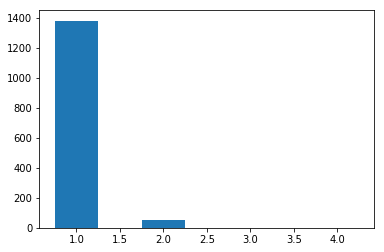

In [524]:
plt.show()

In [525]:
results[:2]

[(Pandas(time_begin=29947, x_begin=11801.55, y_begin=20658.49, time_end=30304, x_end=10247.316951012675, y_end=18694.25012093886),
           time_begin   x_begin   y_begin  time_end        x_end         y_end  \
  trip_id                                                                        
  314119        30064  12765.96  20747.31     30228  11324.73296  20082.597459   
  
           similarity  
  trip_id              
  314119     0.687052  ),
 (Pandas(time_begin=31633, x_begin=17177.04, y_begin=3300.27, time_end=32351, x_end=23973.969132473867, y_end=3117.020023722951),
  None)]

Most of matched ongoing rides have 1 match to them!

-----

#### Saved miles based on Euclidean distance.


In [526]:
match_count = 0
match_kms = []
req_with_match_kms = []
req_kms = []
oo_kms = []
dd_kms = []
oo_times = []
dd_times= []
for req, matches in tqdm_notebook(results):
    req_kms.append(np.sqrt((req.x_begin - req.x_end) ** 2 + (req.y_begin - req.y_end) ** 2 ))
    if(matches is not None):
        match = matches.iloc[0]
        match_count+=1
        req_with_match_kms.append(np.sqrt((req.x_begin - req.x_end) ** 2 + (req.y_begin - req.y_end) ** 2 ))
        match_kms.append(np.sqrt((match.x_begin - match.x_end) ** 2 + (match.y_begin - match.y_end) ** 2 ))
        oo_kms.append(np.sqrt((match.x_begin - req.x_begin) ** 2 + (match.y_begin - req.y_begin) ** 2 ))
        dd_kms.append(np.sqrt((match.x_end - req.x_end) ** 2 + (match.y_end - req.y_end) ** 2 ))
        oo_times.append(match.time_begin - req.time_begin)
        dd_times.append(req.time_end - match.time_end)
        
    

A Jupyter Widget

In [527]:
print("matching with time_threshold of {} and distance_threshold of {}".format(t_th,d_th) )

print("number of req with at least a match:",match_count)

print("match travels (km): ",np.sum(match_kms)/1000)

print("req travels (km): ",np.sum(req_kms)/1000)

print("req travels when they have at least one match (km):",np.sum(req_with_match_kms)/1000)

print("match/match+req ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_kms)))

print("match/match+req with at least 1 match ratio: ",np.sum(match_kms)/(np.sum(match_kms)+np.sum(req_with_match_kms)))

print("origin-origin distance (km): ",np.sum(oo_kms)/1000)

print("dest-dest distance (km): ",np.sum(dd_kms)/1000)

print("origin-origin times (sec): ",np.sum(oo_times))

print("dest-dest times (sec): ",np.sum(dd_times))

matching with time_threshold of 900 and distance_threshold of 1800
number of req with at least a match: 1496
match travels (km):  4356.36832284
req travels (km):  8633.83105683
req travels when they have at least one match (km): 5235.31938089
match/match+req ratio:  0.335358080004
match/match+req with at least 1 match ratio:  0.454181626571
origin-origin distance (km):  1017.66554166
dest-dest distance (km):  1045.91220045
origin-origin times (sec):  70185.0
dest-dest times (sec):  88873.0


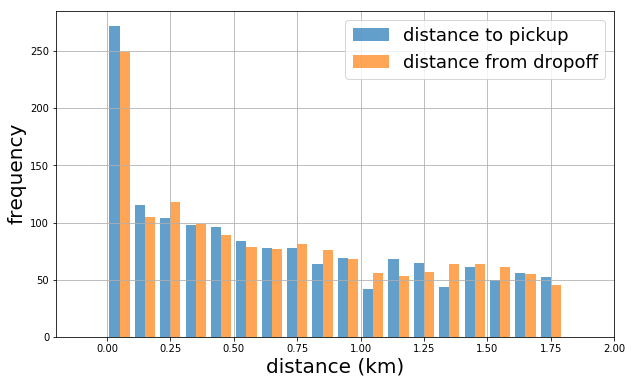

In [528]:
plt.figure(figsize=(10,6))
plt.hist([np.array(oo_kms)/1000,np.array(dd_kms)/1000],alpha=0.7,bins=[i*0.1 for i in range(30)],label=["distance to pickup","distance from dropoff"])
ax = plt.gca()
ax.set_xlim((-.2,2))
ax.set_xlabel("distance (km)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

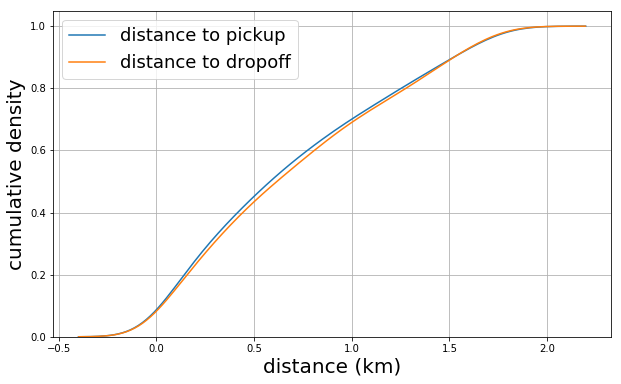

In [529]:
plt.figure(figsize=(10,6))
# plt.gca().set_xlim((-1.5,20))
ax = sns.distplot(np.array(oo_kms)/1000,bins=22,hist=False,kde_kws={'cumulative':True},label="distance to pickup")
sns.distplot(np.array(dd_kms)/1000,bins=22,hist=False,kde_kws={'cumulative':True}, label="distance to dropoff")
ax.set_xlabel("distance (km)",fontsize=20)
ax.set_ylabel("cumulative density",fontsize=20)
plt.grid()
plt.legend(prop = {'size' : 18})
plt.show()

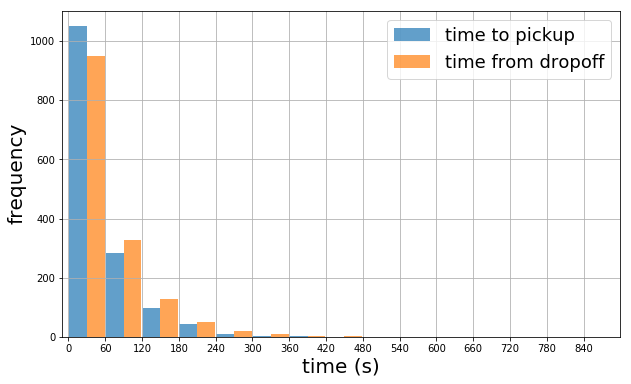

In [530]:
plt.figure(figsize=(10,6))
plt.hist([np.array(oo_times),np.array(dd_times)],alpha=0.7,bins=[i*60 for i in range(10)],label=["time to pickup","time from dropoff"],align='mid',rwidth=0.97)
ax = plt.gca()
ax.set_xlim((-10,900))
plt.xticks(np.arange(0, 900, 60))
ax.set_xlabel("time (s)",fontsize=20)
ax.set_ylabel("frequency",fontsize=20)
plt.grid()
plt.legend(prop={'size': 18})
plt.show()

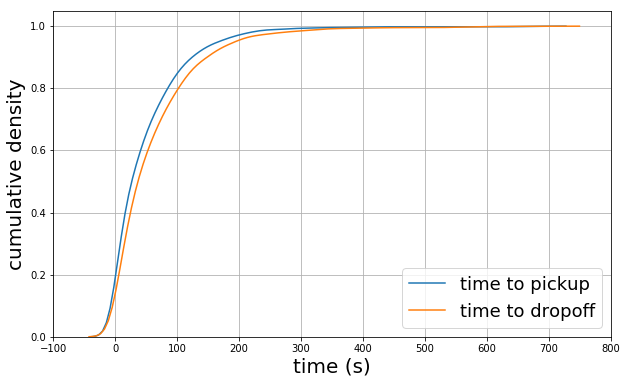

In [531]:
plt.figure(figsize=(10,6))
ax = sns.distplot(np.array(oo_times),hist=False,kde_kws={'cumulative':True},label="time to pickup")
sns.distplot(np.array(dd_times),hist=False,kde_kws={'cumulative':True}, label="time to dropoff")
ax.set_xlabel("time (s)",fontsize=20)
ax.set_ylabel("cumulative density",fontsize=20)
ax.set_xlim((-100,800))
plt.grid()
plt.legend(prop = {'size' : 18})
plt.show()

----


In [573]:
match_counts_per_threshold_cp = []
t_th = 900
distance_threshold = 660 #based on map info (see top of this notebook!)
for i in tqdm_notebook(range(8)):
    thresh = i/2 * distance_threshold
    match_counts = []
    for req in reqDF.itertuples():
        potential_matches = ongoingDF
        
        OO_time_mask = ( (potential_matches.time_begin  <= req.time_begin) & (( req.time_begin - potential_matches.time_begin)<=t_th) )

        potential_matches = potential_matches[OO_time_mask]

        DD_time_mask = ( (req.time_end <= potential_matches.time_end) & (( potential_matches.time_end - req.time_end )<=t_th) )

        potential_matches = potential_matches[DD_time_mask]
        
        
        OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )
        
        potential_matches = potential_matches[(OO_distance <= thresh)] 
        
        DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

        potential_matches = potential_matches[(DD_distance <= thresh)]

        
        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_cp.append((i,thresh,match_counts))

A Jupyter Widget

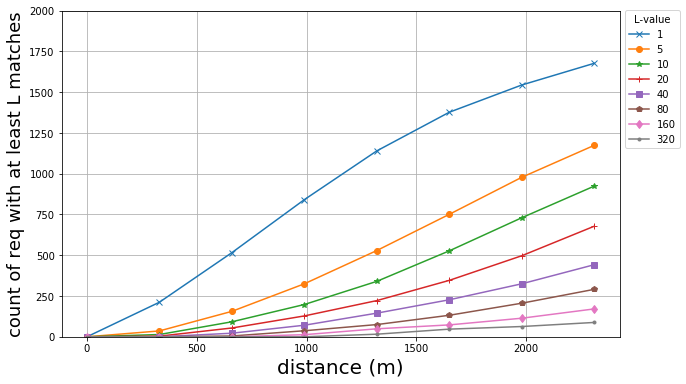

In [574]:
fig = plt.figure(figsize=(10,6))
markers = itertools.cycle(('x', 'o', '*', '+','s','p','d', '.')) 
for l in L_list:
    at_least_l_matches = [(i,j,len([t for t in k if t>=l])) for (i,j,k) in match_counts_per_threshold_cp]
    idx,thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l,marker=next(markers),markevery=1)

plt.gca().set_ylim((0,2000))
plt.gca().set_xlabel("distance (m)",size=20)
plt.gca().set_ylabel("count of req with at least L matches",size=18)
plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
# plt.title("Number of at least L matches per distance threshold (in meters) - Walking" )
plt.grid()
plt.show()

#### Let's change time threshold as well and see what happens

In [580]:
match_counts_per_threshold_cp_timed = []
distance_threshold = 1800
for t in tqdm_notebook([60,300,600,900,1200,1500,1800]):
    match_counts = []
    for req in reqDF.itertuples():
        potential_matches = ongoingDF
        
        OO_time_mask = ( (potential_matches.time_begin  <= req.time_begin) & (( req.time_begin - potential_matches.time_begin)<=t) )

        potential_matches = potential_matches[OO_time_mask]

        DD_time_mask = ( (req.time_end <= potential_matches.time_end) & (( potential_matches.time_end - req.time_end )<=t) )

        potential_matches = potential_matches[DD_time_mask]
        
        
        OO_distance = np.sqrt( (potential_matches.x_begin - req.x_begin) ** 2 + (potential_matches.y_begin - req.y_begin)**2 )
        
        potential_matches = potential_matches[(OO_distance <= distance_threshold)] 
        
        DD_distance = np.sqrt( (potential_matches.x_end - req.x_end) ** 2 + (potential_matches.y_end - req.y_end)**2 )

        potential_matches = potential_matches[(DD_distance <= distance_threshold)]

        
        match_counts.append(len(potential_matches))
    
    match_counts_per_threshold_cp_timed.append((t,match_counts))

A Jupyter Widget

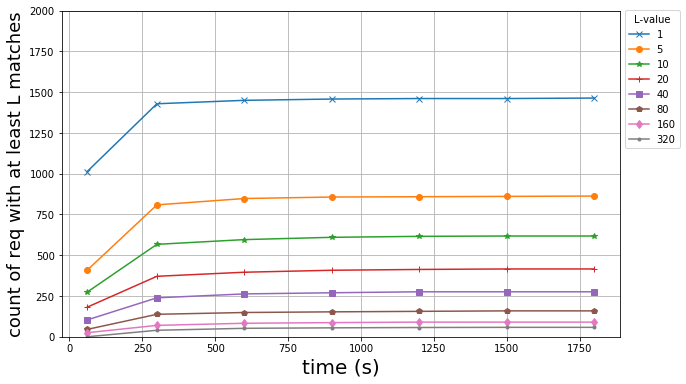

In [581]:
for l in [1,5,10,20,40,80,160,320]:
    at_least_l_matches = [(i,len([t for t in k if t>=l])) for (i,k) in match_counts_per_threshold_cp_timed]
    thresh,ncount = zip(*at_least_l_matches)
    plt.plot(thresh,ncount,label=l,marker=next(markers))
    
fig = plt.gcf()
fig.set_size_inches((10,6))
plt.gca().set_ylim((0,2000))

plt.legend(loc=0,bbox_to_anchor=(1, 1.017),title="L-value")
plt.gca().set_xlabel("time (s)",size=20)
plt.gca().set_ylabel("count of req with at least L matches",size=18)
# plt.title("Number of more than L matches per time threshold (in second)" )
plt.grid()
plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>